<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:0rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2024 @ Author</i></b><br/>
        <i>Author：
            <b>
            <a href="mailto:your_address@email.com">王江海(Jianghai Wang) 📨 </a>
            </b>
        </i>
        <br/>
        <i>Date：2024-03-20</i><br/>
        <i>License：</a><a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Attribution-NonCommercial-ShareAlike 4.0 International</a></i><br/>
    </p>
</div>

> **算法原理**：
> 
> [《计算材料学》算法原理](https://nb.bohrium.dp.tech/detail/52743861357)

In [1]:
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
class Particle:
    def __init__(self, position):
        self._position = np.array(position, dtype=float)

    def __str__(self):
        return f"Particle position =\n{self.position}"

    @property
    def position(self):
        return self._position

    @position.setter
    def position(self, value):
        self._position = np.array(value)

In [3]:
class Box:
    def __init__(self, lower, upper):
        self.lower = np.array(lower,dtype=float)
        self.upper = np.array(upper,dtype=float)
        self.length = self.upper - self.lower

    def __str__(self):
        return f"Box dimension {self.length}"

In [4]:
class BoundaryCondition:
    """Abstract base class for boundary conditions."""

    def apply(self, particles: List[Particle]) -> None:
        raise NotImplementedError

    def displacement(self, position1: np.ndarray, position2: np.ndarray) -> np.ndarray:
        raise NotImplementedError


class PeriodicBoundaryCondition(BoundaryCondition):
    """Implements periodic boundary conditions."""

    def __init__(self, box: Box):
        self.box = box

    def apply(self, particles: List[Particle]) -> None:
        """
        Applies periodic boundary conditions to all particles in the system.

        Parameters
        ----------
        particles : List[Particle]
            List of all Particle instances in the system.
        box : Box
            The Box instance defining the boundaries of the system.

        Returns
        -------
        None

        Notes
        -----
        This method updates the positions of particles in the system
        such that they adhere to the periodic boundary conditions.
        """
        for p in particles:
            p.position = (p.position - self.box.lower) % self.box.length + self.box.lower

    def displacement(self, position1: np.ndarray, position2: np.ndarray) -> np.ndarray:
        """
        Computes the shortest displacement vector between two positions in a periodic system.

        Parameters
        ----------
        position1 : np.array
            Position of the first particle.
        position2 : np.array
            Position of the second particle.
        box : Box
            The box object representing the system's boundary.

        Returns
        -------
        np.array
            The displacement vector from position2 to position1 taking into account periodic boundary conditions.
        """
        dr = position1 - position2
        dr = dr - np.rint(dr / self.box.length) * self.box.length
        return dr

In [5]:
class NeighborList:
    """Abstract base class for neighbor list."""

    def build(self):
        raise NotImplementedError

    def update(self) -> None:
        raise NotImplementedError


class VerletList(NeighborList):

    def __init__(self, particles, box, boundary_condition, cutoff, skin_depth):
        self.particles = particles
        self.box = box
        self.boundary_condition = boundary_condition
        self.cutoff = cutoff
        self.skin_depth = skin_depth

    def build(self):
        """Build neighbor list of the particle."""
        self.neighbor_list = []
        self.previous_positions = [p.position for p in self.particles]

        for i, p1 in enumerate(self.particles):
            self.neighbor_list[i] = []
            for p2 in self.particles:
                displacement = self.boundary_condition.displacement(p1.position, p2.position, self.box)
                if p1 != p2 and np.linalg.norm(displacement) < (self.cutoff + self.skin_depth):
                    self.neighbor_list[i].append(p2)

    def update(self):
        max_displacement = max(
            np.linalg.norm(self.boundary_condition.displacement(p.position, self.previous_positions[p], self.box)) for p
            in self.particles)
        if max_displacement > self.skin_depth / 2:
            self.build()

In [6]:
class Potential:
    """Abstract base class for potential."""
    def energy_calc(self, particles, start_dist, end_dist):
        raise NotImplementedError

    def force_calc(self, particles, start_dist, end_dist):
        raise NotImplementedError


class LJPotential(Potential):

    def __init__(self, box, pbc, epsilon, sigma, start_dist=3, end_dist=6, cutoff='soft'):
        self.box = box
        self.pbc = pbc
        self.epsilon = epsilon
        self.sigma = sigma
        self.start_dist = start_dist
        self.end_dist = end_dist


        if cutoff not in ['hard', 'soft']:
            raise ValueError('Invalid type of cutoff.')
        else:
            self.cutoff = cutoff

    def _switching_function(self, r, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        # Check the distance against the switching start and cutoff distance
        if r < start_dist:
            return 1.0
        elif r > end_dist:
            return 0.0

        # Compute the normalized distance within the switching interval
        # t = 1 when r = start_dist;  t = 0 when r = end_dist
        t = (end_dist - r) / (end_dist - start_dist)

        # Compute the switching function based on the chosen method

        return 0.5 * (1 - np.cos(np.pi * t))

    def _switching_derivative(self, r, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        if r < start_dist or r > end_dist:
            return 0.0
        else:
            return -0.5 * (np.pi / (end_dist - start_dist)) * np.sin(np.pi * (end_dist - r) / (end_dist - start_dist))

    def _energy_calc(self, r, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        if r <= end_dist:
            if self.cutoff == 'hard':
                V = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)
                return V

            if self.cutoff == 'soft':
                V = (self._switching_function(r, start_dist, end_dist) *
                     4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6))
                return V

        else:
            return 0

    def _force_calc(self, r_vec, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        r_magnitude = np.linalg.norm(r_vec)

        if r_magnitude <= end_dist:
            # Compute force without considering cutoff
            force_magnitude = 24 * epsilon * (
                    (2 * (sigma / r_magnitude) ** 12) - (sigma / r_magnitude) ** 6) / r_magnitude

            if self.cutoff == 'soft':
                switching_value = self._switching_function(r_magnitude, start_dist, end_dist)
                switching_derivative = self._switching_derivative(r_magnitude, start_dist, end_dist)
                force_magnitude *= switching_value
                # Add extra force due to derivative of switching function
                force_magnitude -= switching_derivative * 4 * epsilon * (
                        (sigma / r_magnitude) ** 12 - (sigma / r_magnitude) ** 6)
        else:
            force_magnitude = 0.0

        return force_magnitude

    def _force_vector(self, r_vec, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist
        r_magnitude = np.linalg.norm(r_vec)
        force_magnitude = self._force_calc(r_vec, start_dist, end_dist)
        # Add force vector to total force
        net_force = force_magnitude * (r_vec / r_magnitude)

        return net_force

    def Energy(self, particles, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        atom_energy = np.zeros(len(particles))

        for i, p1 in enumerate(particles):
            for p2 in particles:
                if p2 is not p1:
                    r_vec = self.pbc.displacement(p1.position, p2.position)
                    r = np.linalg.norm(r_vec)
                    atom_energy[i] = atom_energy[i] + 0.5 * self._energy_calc(r, start_dist, end_dist)

        energy = np.sum(atom_energy)

        return np.array(energy)

    def Force(self, particles, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        force_vector = np.zeros((len(particles), 3))

        for i, p1 in enumerate(particles):
            for p2 in particles:
                if p2 != p1:
                    r_vec = self.pbc.displacement(p1.position, p2.position)
                    f_v = self._force_vector(r_vec, start_dist, end_dist)
                    force_vector[i] += f_v

        return force_vector

    def dEdR(self, particles, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        gradient = np.zeros((len(particles), 3))
        for i, p1 in enumerate(particles):
            for p2 in particles:
                if p2 != p1:
                    r_vec = self.pbc.displacement(p1.position, p2.position)
                    force_vector = self._force_vector(r_vec, start_dist, end_dist)
                    gradient[i] += force_vector

        gradient = - gradient.flatten()

        return gradient

In [7]:
class OptimizationAlgorithm:
    def __init__(self, box, pbc, potential, max_iters=10000, tol=1e-6, alpha=0.5, beta=0.5):
        self.box = box
        self.pbc = pbc
        self.potential = potential
        self.max_iters = max_iters
        self.tol = tol
        self.alpha = alpha
        self.beta = beta

    def backtrack_line_search(self, particles, descent_dir):
        x = np.array([p.position for p in particles])
        t = 1.0
        new_x = x + t * descent_dir.reshape(len(particles), 3)
        new_particles = []
        for i in range(natoms):
            new_particles.append(Particle(new_x[i]))

        e = self.potential.Energy(particles)
        new_e = self.potential.Energy(new_particles)
        g = self.potential.dEdR(particles)

        while new_e > (e + self.alpha * t * np.dot(g, descent_dir)):
            t *= self.beta
            new_x = x + t * descent_dir.reshape(len(particles), 3)
            new_particles = []
            for i in range(natoms):
                new_particles.append(Particle(new_x[i]))

            new_e = self.potential.Energy(new_particles)

        return t

    def steepest_descent(self, ini_pts, max_iters=None, tol=None, snap_interval=50):
        if max_iters is None:
            max_iters = self.max_iters

        if tol is None:
            tol = self.tol

        particles = ini_pts
        x = np.array([p.position for p in particles])
        path = [x]
        print("========================================================================================================================")
        for i in range(max_iters):
            e = self.potential.Energy(particles)
            g = self.potential.dEdR(particles)
            d = - g
            alpha = self.backtrack_line_search(particles, d)
            new_x = x + alpha * d.reshape(len(particles), 3)
            for j, p in enumerate(particles):
                p.position = new_x[j]
            self.pbc.apply(particles)

            new_x = np.array([p.position for p in particles])

            if i % snap_interval == 0:
                path.append(new_x)
                print("Iter: {}\nPosition:\n{}\nEnergy: {}".format(i + 1, x, e))
                print("------------------------------------------------------------------------------------------------------------------------")

            if np.linalg.norm(d) < tol:
                break
            x = new_x
        print("========================================================================================================================")
        return np.array(path)

    def conjugate_gradient(self, ini_pts, max_iters=None, tol=None, snap_interval=500):
        if max_iters is None:
            max_iters = self.max_iters

        if tol is None:
            tol = self.tol

        particles = ini_pts
        x = np.array([p.position for p in particles])
        path = [x]
        print("========================================================================================================================")
        g = self.potential.dEdR(particles)
        d = - g
        for i in range(max_iters):
            alpha = self.backtrack_line_search(particles, d)
            new_x = x + alpha * d.reshape(len(particles), 3)

            for j, p in enumerate(particles):
                p.position = new_x[j]
            self.pbc.apply(particles)

            new_x = np.array([p.position for p in particles])
            if i % snap_interval == 0:
                path.append(new_x)
                new_e = self.potential.Energy(particles)
                print("Iter: {}\nPosition:\n{}\nEnergy: {}".format(i + 1, new_x, new_e))
                print("------------------------------------------------------------------------------------------------------------------------")
            
            g_next = - self.potential.dEdR(particles)
            beta = np.dot(g_next, g_next) / np.dot(g, g)
            d = g_next + beta * d
            g = g_next
            if np.linalg.norm(g) < tol:
                break
            x = new_x
        print("========================================================================================================================")
        return np.array(path)

In [8]:
def genRandomParticles(natoms, system_scale=10):
    # Generate random atom positions
    dim = 3  # 3 dimensional
    minDist = 0.8  # minimum required distance between atoms
    positions = np.zeros((natoms, dim))
    positions[0] = np.random.rand(dim)
    for i in range(1, natoms):
        iter, maxIter = 0, 1e5
        while True and iter < maxIter:
            iter += 1
            newpos = np.random.rand(dim) * system_scale
            dist = newpos - positions[0:i]
            if np.all(np.linalg.norm(dist, axis=1) > minDist):
                break
        assert (iter < maxIter)
        positions[i] = newpos

    particles = []
    for i in range(natoms):
        particles.append(Particle(positions[i]))

    return particles

In [9]:
def visualize(path):
    positions = np.array(path)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.axis('off')

    vertices = np.array([[0, 0, 0],
                         [system_scale, 0, 0],
                         [system_scale, system_scale, 0],
                         [0, system_scale, 0],
                         [0, 0, system_scale],
                         [system_scale, 0, system_scale],
                         [system_scale, system_scale, system_scale],
                         [0, system_scale, system_scale]])

    edges = [(0, 1), (1, 2), (2, 3), (3, 0),
             (4, 5), (5, 6), (6, 7), (7, 4),
             (0, 4), (1, 5), (2, 6), (3, 7)]

    for edge in edges:
        ax.plot3D(*zip(vertices[edge[0]], vertices[edge[1]]), color="grey")

    # 初始时刻原子坐标
    sc = ax.scatter(positions[0][:, 0], positions[0][:, 1], positions[0][:, 2], s=100)

    # 时间标签
    time_label = ax.text2D(0.05, 0.9, '', transform=ax.transAxes)

    # 更新函数
    def update(frame):
        sc._offsets3d = (positions[frame][:, 0], positions[frame][:, 1], positions[frame][:, 2])
        time_label.set_text('Step = %d' % frame)

    # 创建动态图
    anim = FuncAnimation(fig, update, frames=len(positions), interval=500, blit=False)

    plt.show()

In [10]:
# Parameters
natoms = 10
system_scale = 5
start_dist = 3
cutoff_dist = 6
skin_depth = 2
epsilon = 1.0
sigma = 1.0
snap_interval = 50

Iter: 1
Position:
[[0.86892896 0.79713155 0.02681843]
 [1.96415895 3.09563507 3.14510863]
 [4.00139061 1.01012325 0.44174485]
 [0.21403769 2.23908333 1.11137933]
 [3.18090857 2.52825807 3.49071087]
 [2.70517585 1.97291743 1.77204115]
 [4.52691155 1.51721319 2.65673965]
 [2.20925933 2.64792217 4.92658152]
 [4.00155627 2.72676931 1.36209044]
 [1.93950459 0.75976008 1.01256903]]
Energy: -3.4488551608422515
------------------------------------------------------------------------------------------------------------------------
Iter: 51
Position:
[[0.95633318 1.42239163 0.90510002]
 [2.09080161 2.89560061 3.40553294]
 [3.93113925 1.29046073 0.87425591]
 [4.89955964 1.73869879 1.19738016]
 [3.076054   2.36746891 3.4979249 ]
 [3.08456605 1.72219417 1.47822751]
 [4.09649888 1.55277906 1.95163303]
 [2.41995579 2.49582294 4.40492448]
 [3.97033191 2.36167026 1.19225088]
 [2.08659208 1.44772635 1.03855408]]
Energy: -15.811314866393534
----------------------------------------------------------------

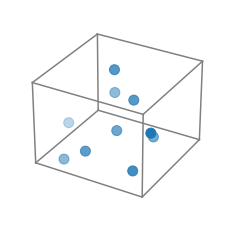

In [11]:
# Generate random particles
particles = genRandomParticles(natoms, system_scale)

# Instantiate
box = Box(np.array([0.0, 0.0, 0.0]), np.array([system_scale, system_scale, system_scale]))
pbc = PeriodicBoundaryCondition(box)
pbc.apply(particles)

lj_potential = LJPotential(box, pbc, epsilon, sigma, cutoff='soft')

optimizer = OptimizationAlgorithm(box, pbc, lj_potential)
sd_path = optimizer.steepest_descent(particles, snap_interval=snap_interval)

energies = []
for x in sd_path:
    pts = []
    for i in range(len(x)):
        pts.append(Particle(x[i]))
    energies.append(lj_potential.Energy(pts))
energies = np.array(energies)

visualize(sd_path)